In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder


In [2]:
#transformamos las imagenes para poder alimentar a la rnn
transform = transforms.Compose([
    transforms.ToTensor()  #normalizamos
])

#lugar en donde estan las imagenes
data_path = "data/images_original"

# Cargar los datos de entrenamiento desde la carpeta
train_dataset = ImageFolder(root=data_path, transform=transform)

# Dividir los datos en entrenamiento y validación
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# Crear DataLoader para cargar los datos en lotes durante el entrenamiento
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)


In [3]:
import torch.nn.functional as F
class Classification_CNN(nn.Module):
    def __init__(self):
        '''
        Red convolucional que cuenta con los siguientes datos:

        - Una capa convolucional con filtro de 3x3 y 64 filtros. Activación RELU
        - Maxpooling de 2x2
        - Capa convolucional con filtro de 2x2 y 32 filtros. Activación RELU
        - Maxpooling de 2x2
        - Capa convolucional con filtro de 2x2 y 16 filtros. Activación RELU
        - Maxpooling de 2x2
        - Capa convolucional con filtro de 2x2 y 8 filtros. Activación RELU
        - Maxpooling de 2x2
        - Capa totalmente conectada para clasificar con 1024 neuronas. Activación RELU
        '''
        super(Classification_CNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size = 2, stride = 2, padding = 1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size = 2, stride = 2, padding = 1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv3 = torch.nn.Conv2d(32, 16, kernel_size = 2, stride = 2, padding = 1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv4 = torch.nn.Conv2d(16, 8, kernel_size = 2, stride = 2, padding = 1)
        self.pool4 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #como la imagen de entrada es de 224x224 y hacemos 3 maxpooling de 2x2, entonces la imagen de salida es de 224/2/2/2 = 28x28
        self.fc1 = torch.nn.Linear(8*1*2, 1024)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.fc2 = torch.nn.Linear(1024, 10)        

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        output = F.relu(self.conv1(x))
        output = self.pool1(output)

        output = F.relu(self.conv2(output))
        output = self.pool2(output)

        output = F.relu(self.conv3(output))
        output = self.pool3(output)

        output = F.relu(self.conv4(output))
        output = self.pool4(output)


        # print(f'output shape: {output.shape}')
        output = output.view(output.size(0), -1)
        # print(f'output shape flatten: {output.shape}')

        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        # print(f'output shape fc1: {output.shape}')
        output = F.relu(self.fc2(output))

        #agregamos un softmax para obtener las probabilidades
        output = F.softmax(output, dim=1)
        return output
    
    def train(self, epochs, data_loader, criterion, optimizer):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        train_graph = []
        

        #si encontramos un modelo con el error más bajo que el actual, lo guardamos
        best_loss = np.inf

        for epoch in range(epochs):
            train_loss = 0
            for i, (inputs, labels) in enumerate (data_loader):

                #limpiamos los gradientes
                optimizer.zero_grad()

                #feedforward y backpropagation
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                train_loss += loss.item() * inputs.size(0)
                loss.backward()
                optimizer.step()

                #guardamos el modelo con el menor error
                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(self.state_dict(), 'best_model.pt')

            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

            #perdida promedio 
            train_loss = train_loss / len(train_dataset)
            train_graph.append(train_loss)

        plt.plot(train_graph)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.grid()
        plt.show()

        print('Finished Training')

    def test(self,data_loader):

        correct = 0
        total = 0
        with torch.no_grad():
            for data in data_loader:
                images, labels = data
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print("Accuracy: {}".format(correct/total))

    def conf_matrix(self, data_loader):
        y_pred = []
        y_true = []
        with torch.no_grad():
            for data in data_loader:
                images, labels = data
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.extend(predicted)
                y_true.extend(labels)
        cm = confusion_matrix(y_true, y_pred)

        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.show()

        #mostramos el reporte de clasificación
        print(classification_report(y_true, y_pred))


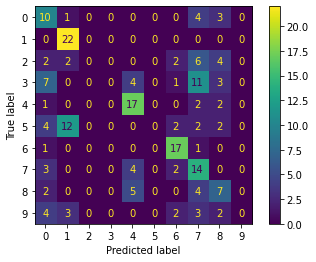

              precision    recall  f1-score   support

           0       0.29      0.56      0.38        18
           1       0.55      1.00      0.71        22
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        26
           4       0.57      0.77      0.65        22
           5       0.00      0.00      0.00        22
           6       0.65      0.89      0.76        19
           7       0.30      0.61      0.40        23
           8       0.30      0.39      0.34        18
           9       0.00      0.00      0.00        14

    accuracy                           0.43       200
   macro avg       0.27      0.42      0.32       200
weighted avg       0.27      0.43      0.33       200



C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
#cargamos la red entrenada 
Red_CNN = Classification_CNN()
Red_CNN.load_state_dict(torch.load('modelos/modelo_cnn.pth'))

cm = Red_CNN.conf_matrix(valid_loader)

Epoch [1/500], Step [25/25], Loss: 1.9796054363250732
Epoch [2/500], Step [25/25], Loss: 2.0294253826141357
Epoch [3/500], Step [25/25], Loss: 2.173448085784912
Epoch [4/500], Step [25/25], Loss: 1.933656096458435
Epoch [5/500], Step [25/25], Loss: 2.060426712036133
Epoch [6/500], Step [25/25], Loss: 2.020918130874634
Epoch [7/500], Step [25/25], Loss: 2.1324362754821777
Epoch [8/500], Step [25/25], Loss: 1.9990167617797852
Epoch [9/500], Step [25/25], Loss: 2.1412034034729004
Epoch [10/500], Step [25/25], Loss: 1.9542393684387207
Epoch [11/500], Step [25/25], Loss: 2.0508458614349365
Epoch [12/500], Step [25/25], Loss: 1.852338433265686
Epoch [13/500], Step [25/25], Loss: 1.957266926765442
Epoch [14/500], Step [25/25], Loss: 2.0711922645568848
Epoch [15/500], Step [25/25], Loss: 2.056641101837158
Epoch [16/500], Step [25/25], Loss: 2.17594575881958
Epoch [17/500], Step [25/25], Loss: 2.079230308532715
Epoch [18/500], Step [25/25], Loss: 1.983096957206726
Epoch [19/500], Step [25/25], 

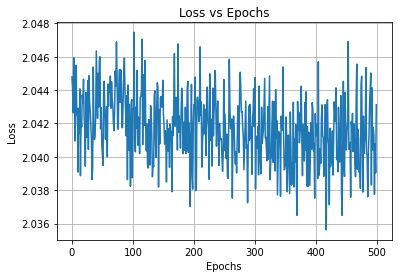

Finished Training


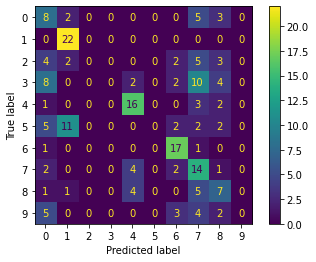

              precision    recall  f1-score   support

           0       0.23      0.44      0.30        18
           1       0.58      1.00      0.73        22
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        26
           4       0.62      0.73      0.67        22
           5       0.00      0.00      0.00        22
           6       0.61      0.89      0.72        19
           7       0.29      0.61      0.39        23
           8       0.29      0.39      0.33        18
           9       0.00      0.00      0.00        14

    accuracy                           0.42       200
   macro avg       0.26      0.41      0.31       200
weighted avg       0.27      0.42      0.32       200



C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
optimizer = optim.Adam(Red_CNN.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()
Red_CNN.train(500, train_loader, criterion, optimizer)

#matriz de confusion
cm = Red_CNN.conf_matrix(valid_loader)

#guardamos el modelo
torch.save(Red_CNN.state_dict(), 'modelos/modelo_cnn.pth')

In [6]:
torch.save(Red_CNN.state_dict(), 'modelos/modelo_cnn.pth')

In [12]:
#ponemos una semilla
torch.manual_seed(2001)

Red_Adam = Classification_CNN()

#cargamos el modelo
Red_Adam.load_state_dict(torch.load('modelos/modelo_cnn_adam.pth'))
optimizer = optim.Adam(Red_Adam.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

Red_Adam.train(50, train_loader, criterion, optimizer)

#matriz de confusion
cm = Red_Adam.conf_matrix(valid_loader)